# Random Walks

Random walks are a class of stochastic processes that describe the trajectory of an object through some mathematical space. In the typical case, one considers some state, $\mathbf{z}_t \in \mathbb{R}^d$, that is successively incremented between discrete time intervals by drawing random variables from some probability distribution. Random walks have ben used extensively in biology to describe the motion of biological objects on various scales. In our specific context, we are seeking a model for cell migration in the vicinity of a wound. 

<br>

## The biased-persistent random walk

The model that Weavers *et al* opt for is known as a *biased-persistent* random walk. The terms 'bias' and 'persistence' refer to two distinct phenomena observed in cell migration. Cells with a high bias have a strong tendency to drift towards a static global position, and cells with a high persistence tend to take successive steps that are oriented in the same general direction.

<br>

Mathematically, the model is formulated as follows. A cell is defined by three parameters $w$, $p$ and $b$, each of which take a value on the interval $[0, 1]$. The cell exists in an environment of two dimensional Euclidean space and its state, at any one time, is simply its $x$-$y$ coordinates. At each discretised time step, the cell makes a jump of length $s_t$, at an angle $\alpha_t$ defined with reference to an arbitrary fixed axis. The step size $s_t$ is generated by drawing from a *truncated normal* distribution, with a probability density function

<br>

$$
\mathcal{N}^{+}(s_t;  \, \sigma) =
\begin{cases}
0 & \text{if} \,\, s_t < 0 \\
2 \, \mathcal{N}(s_t; \, 0, \, \sigma) & \text{if} \,\, s_t \geq . 0\\
\end{cases}
$$

<br>

This distribution is static and does not depend on the input parameters $w$, $p$ or $b$. The value of $\sigma$ sets the typical step size and should be proportional to the square root of the time interval $\Delta t$, although, in practice, the scale used here is mostly a matter of bookkeeping. The turning angle $\alpha_t$ is drawn from a dynamic distribution that depends on the current angle towards the source $\beta_t$, and the previous angle $\alpha_{t-1}$. At each step, the cell chooses to follow either biased motion, with probability $w$, or persistent motion, with probability $1-w$. The turning angle is then drawn from a \emph{wrapped normal} distribution $\mathcal{N}_{\,\,\,\text{w}}(\theta; \, \mu, \, \sigma)$. The probability density function for this distribution is defined as

<br>

$$
\mathcal{N}_{\text{w}}(\theta; \, \mu, \, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \sum_{k=-\infty}^{\infty} \exp \big( - \frac{(\theta - \mu + 2 \pi k)^{2}}{2 \sigma ^{2}} \big), 
$$

<br>

If biased motion is followed, the parameter of this distribution are set as $\mu=\beta_t$ and $\sigma=-2\log b$. If persistent motion is followed, the parameters are $\mu=\alpha_{t-1}$ and $\sigma=-2\log p$. Thus, a biased persistent walk can be generated by the following algorithm:

1. At each time step, generate a random number between 0 and 1. 
2. If this is less than $w$, set $\sigma = -2\log b$ and $\mu = \beta_{t}$. If it is greater than $w$ set $\sigma = -2\log p$ and $\mu = \alpha_{t-1}$. 
4. Draw a random angle from the wrapped normal distribution, $\mathcal{N}_{\text{w}}(\alpha_{t}; \, \mu, \, \sigma)$
5. Draw a random step from the truncated normal distribution $\mathcal{N}^{+}(s_{t}; \, 0, \, \sqrt{dt})$
6. Update the walker's coordinates and repeat. 

## Exploring the wrapped normal distribution

In [1]:
# allow imports from the LM package
import os
import sys
sys.path.append(os.path.abspath('..'))

In [6]:
# import stuff for interactive plots. Run this cell twice!!
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
%matplotlib notebook

In [7]:
# from the LM package
from utils.distributions import WrappedNormal
from utils.plotting import add_pi_ticks
%matplotlib notebook

### Sampling from the warpped normal distribution

<IPython.core.display.Javascript object>


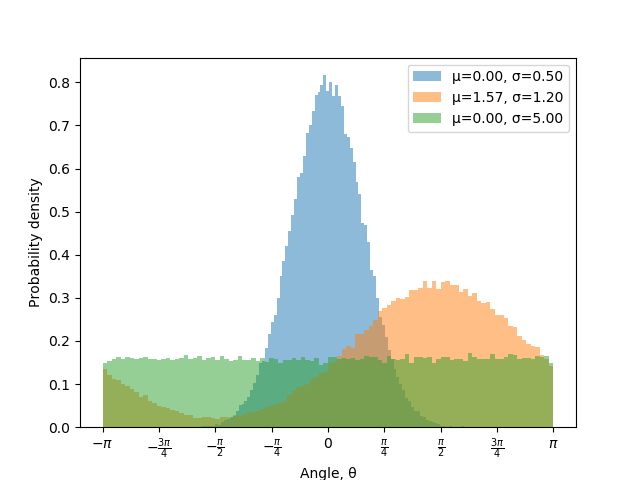

Text(0, 0.5, 'Probability density')

In [8]:
fig, ax = plt.subplots()
add_pi_ticks(ax)

for mu, sig in zip([0, np.pi/2, 0], [0.5, 1.2, 5]):
    sample = WrappedNormal(mu, sig).sample(100000)
    plt.hist(sample, bins=100, alpha=0.5, density=True, label='μ={:.2f}, σ={:.2f}'.format(mu, sig))

plt.legend()
plt.xlabel('Angle, θ')
plt.ylabel('Probability density')

## Plotting the probability density function

Use the sliders!

<IPython.core.display.Javascript object>


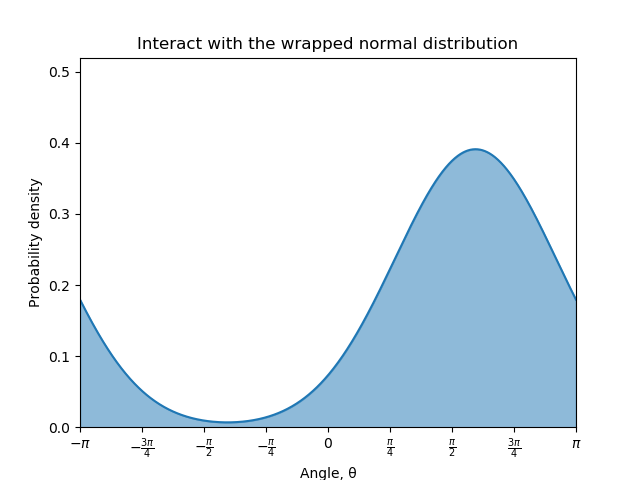

interactive(children=(FloatSlider(value=0.0, description='μ', max=3.141592653589793, min=-3.141592653589793, s…

interactive(children=(FloatSlider(value=1.5, description='σ', max=4.0, min=0.8, step=0.01), Output()), _dom_cl…

In [9]:
distribution = WrappedNormal(mu=0, sig=1.5)
theta = np.linspace(-np.pi, np.pi, 1000)

fig, ax = plt.subplots()
add_pi_ticks(ax)
plt.title('Interact with the wrapped normal distribution')
plt.xlabel('Angle, θ')
plt.ylabel('Probability density')

ax.set_ylim(0, 0.52)
ax.set_xlim(-np.pi, np.pi)
y = distribution.pdf(theta)
line, = ax.plot(theta, y)
fill = ax.fill_between(theta, 0, y, alpha=0.5)

def update_y():
    global fill
    y = distribution.pdf(theta)
    line.set_ydata(y)
    fill.remove()
    fill = ax.fill_between(theta, 0, y, alpha=0.5, color='#1f77b4')
    fig.canvas.draw_idle()

def update_sigma(σ=1.5):
    distribution.sig = σ
    update_y()
    
def update_mu(μ=0):
    distribution.mu = μ
    update_y()
    
interact(update_mu, μ=(-np.pi, np.pi, 0.01));
interact(update_sigma, σ=(0.8, 4, 0.01));

## Simluating biased-persistent trajectories

<IPython.core.display.Javascript object>


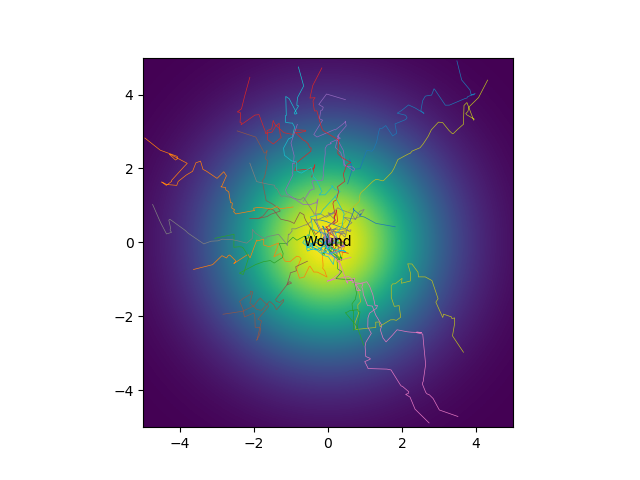

The paths object has shape (51, 2, 20): (T+1, [x, y], n_walkers)


In [8]:
from utils.distributions import Normal
from in_silico.walkers import BP_Leukocyte
from in_silico.sources import PointSource

fig, ax = plt.subplots()
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)

# add a background gradient
X, Y = np.meshgrid(*[np.linspace(-5, 5, 1001)]*2)
R = (X ** 2 + Y ** 2) ** 0.5
plt.imshow(Normal(mu=0, sig=2).pdf(R), extent=(-5, 5, -5, 5))
ax.text(0, 0, 'Wound', ha='center', va='center')

# make a source (for the walkers to migrate towards) 
source = PointSource(position=np.array([0, 0]))

# instantiate a walker with parameters w=0.5, p=0.6, b=0.7
params = np.array([0.5, 0.6, 0.7])
walker = BP_Leukocyte(params, source)

# these are the starting positions of the leukocytes. Size must be of the form (N, 2)
n_walkers = 20
X0s = np.random.uniform(-5, 5, size=(n_walkers, 2))
paths = walker.walk(X0s, T=50)

# plot the trajectories
for i in range(n_walkers):
    plt.plot(paths[:, 0, i], paths[:, 1, i], linewidth=0.5, alpha=1)
    
print('The paths object has shape {}: (T+1, [x, y], n_walkers)'.format(paths.shape))
